In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

# Precipitation Analysis

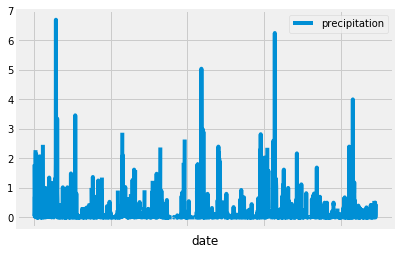

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# Returns last date as '2017-08-23'
query_date = dt.date(2017,8,23) - dt.timedelta(days=365)
# Returns query date as '2016-08-23'

# Perform a query to retrieve only the data and precipitation scores
precipitation_scores = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(precipitation_scores, columns=['date','precipitation'])
prcp_df.set_index('date', inplace=True)

# Sort the dataframe by date
prcp_df = prcp_df.sort_index(ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot()
plt.savefig("Images/precipitation_analysis.png")
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df["precipitation"].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Station Analysis

In [12]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.station).count()
print(stations)

9


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station = session.query(Measurement.station, func.count(Measurement.tobs)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.tobs).desc()).all()
active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
active_sta_temp = session.query(Measurement.tobs).\
filter(Measurement.station == 'USC00519281').all()

temp_df = pd.DataFrame(active_sta_temp, columns=['temperature: '])
print('Highest', temp_df.max())
print('Lowest', temp_df.min())
print('Average', temp_df.mean())

Highest temperature:     85.0
dtype: float64
Lowest temperature:     54.0
dtype: float64
Average temperature:     71.663781
dtype: float64


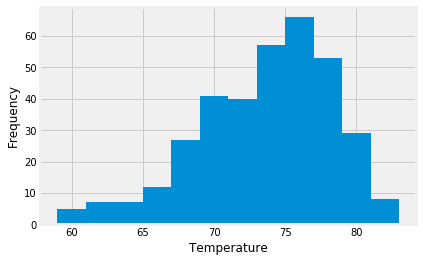

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_scores = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
filter(Measurement.station == 'USC00519281').\
filter(Measurement.date >= query_date).all()

temps = [x[2] for x in temperature_scores]
plt.hist(temps, bins=12)
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.savefig("Images/temperature_analysis.png")
plt.show()

# Temperature Analysis (Optional)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVG, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = calc_temps('2017-08-09', '2017-08-23')
print(trip)

[(70.0, 78.64406779661017, 85.0)]


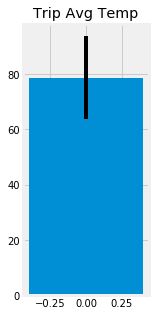

In [18]:
# Plot the results from your previous query as a bar chart.
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
calc_temperature_d = {'TMIN': [70.0], 'TAVG': [78.64406779661017], 'TMAX': [85.0]}
calc_temperature_df = pd.DataFrame(calc_temperature_d)

plt.figure(figsize=(2,5))
TMIN = calc_temperature_df["TMIN"]
TAVG = calc_temperature_df["TAVG"]
TMAX = calc_temperature_df["TMAX"]
plt.bar(0, height=TAVG, yerr = (TMAX - TMIN))
plt.title("Trip Avg Temp")
plt.savefig("Images/trip_avg_temp.png")
plt.show()


# Other Recommended Analysis (Optional)

In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
Rainfall = session.query(Measurement.station, func.sum(Measurement.prcp)).\
filter(Measurement.date >= '2017-08-09').\
group_by(Measurement.station).all()
Rainfall


[('USC00514830', 0.04),
 ('USC00516128', 3.1500000000000004),
 ('USC00519281', 0.51),
 ('USC00519397', 0.02),
 ('USC00519523', 0.34)]

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("08-09")

[(69.0, 75.98039215686275, 81.0)]